In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import minmax_scale
from anndata import AnnData
from math import ceil

# Libs for Venn-diagramm
import matplotlib.pyplot as plt
import matplotlib

# Libs for Upsetplot
from upsetplot import from_contents
from upsetplot import UpSet
from matplotlib import pyplot as plt
from upsetplot import generate_counts, plot
import matplotlib.patches as mpatches

import seaborn as sb
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.ticker import FormatStrFormatter

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.r('library("hypeR")')
ro.r("source(paste('/lustre/groups/ml01/code/k.noerenberg/diabetes_analysis/data_exploration/helper_hypeR.R'))")

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [ ]:
%%R
library('ComplexHeatmap')
library(viridis)

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_sexaging_covarSample/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

In [5]:
# Add full gene symbol info
adata_rn_b.var['gene_symbol']=h.get_symbols(adata_rn_b.var_names)
# Check that gene symbols not nan -
if (adata_rn_b.var.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

In [6]:
# load genes info for expression, rel beta expression, and citation info
genes_info=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/genePrioritisation_beta.tsv',index_col=0)

In [8]:
# Make pb adata 
data=adata_rn_b.to_df()
data['group']=adata_rn_b.obs['leiden_r20']
data=data.groupby('group').mean()
adata_pb=AnnData(data)
adata_pb.shape

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(411, 30672)

Select DE genes

In [9]:
# Load DE data
result=pickle.load(
    open(path_de+'maleFemale_Fltp_2y_0.05.pkl','rb'))
summary=result.summary()
summary.index=summary.gene
# Filter summary
summary = summary[summary.coef_sd>2.2227587494850775e-162]

In [10]:
# Set Threshold for FDR, ALFC as in BSc_sexdiff_maleFemale_DE_Fltp_2y
FDR = 0.05
ALFC = 1

In [11]:
# Change adata_genes so that code from other notebooks can be reused
adata_genes=adata_pb[:,summary.query('qval<@FDR & abs(log2fc)>@ALFC').index].copy().T

Relative beta expression is not importent for filtering here as DE using same samples so not expecting ambient effects

# Clusters for up and down DE genes

In [183]:
# Delete the adata_genes.obs['hc'] if it already exists
if 'hc' in adata_genes.obs.columns:
    adata_genes.obs.drop('hc',axis=1,inplace=True)

In [184]:
# set cut treshold
cut_thresh = 1.45

Up regulated Genes

In [186]:
# Compute hc for up-regulated genes
genes_up=[g for g in adata_genes.obs_names if summary.at[g,'log2fc']>0]
dist=pdist(adata_genes[genes_up,:].X,metric='correlation')
hc=linkage(dist, method='ward',  optimal_ordering=True)

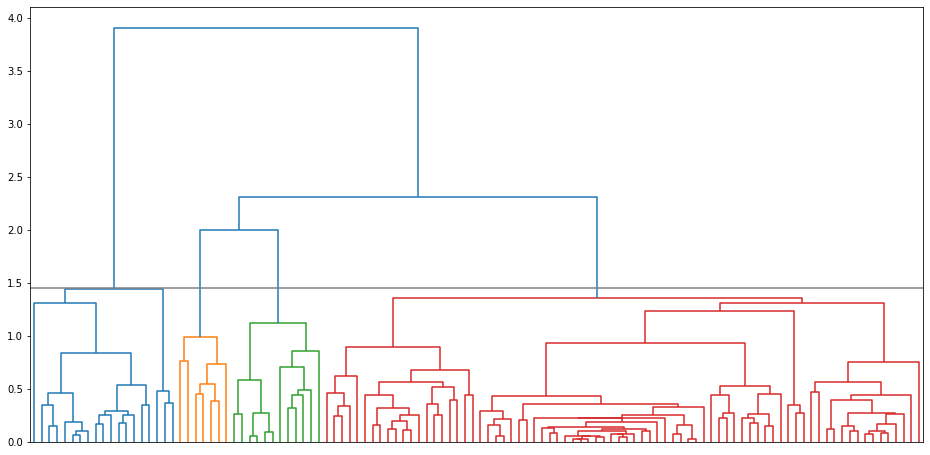

In [187]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
adata_genes.uns['hc_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
hierarchy.set_link_color_palette(adata_genes.uns['hc_colors'])
dend=dendrogram(hc,color_threshold=cut_thresh,no_labels=True)
plt.axhline(cut_thresh,c='gray')

In [188]:
# Extract clusters at selected cutting threshold
adata_genes.obs.loc[genes_up,'hc']=['up_'+str(cl)
                                      for cl in fcluster(hc,t=cut_thresh,criterion='distance')]

Down regulated genes

In [190]:
# Compute hc for down-regulated genes
genes_down=[g for g in adata_genes.obs_names if summary.at[g,'log2fc']<0]
dist=pdist(adata_genes[genes_down,:].X,metric='correlation')
hc=linkage(dist, method='ward',  optimal_ordering=True)

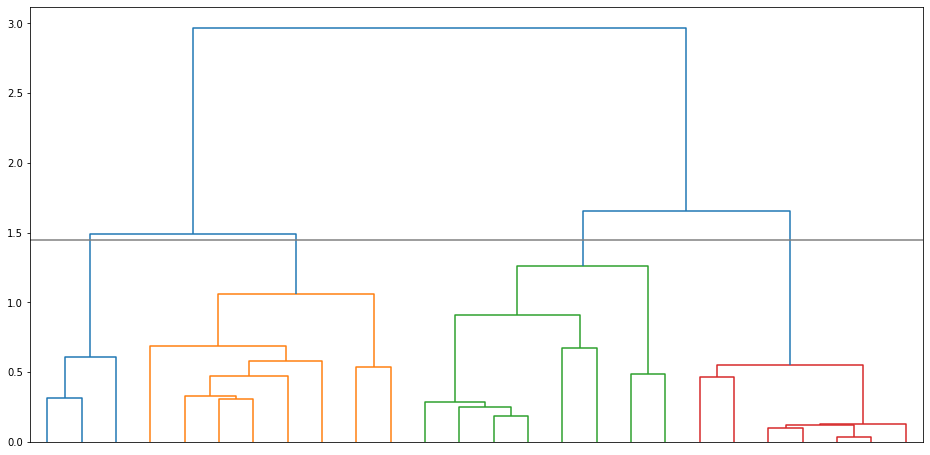

In [191]:
# Plot dendrogram
rcParams['figure.figsize']=(16,8)
adata_genes.uns['hc_colors']=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
                'tab:brown','tab:pink', 'tab:gray', 'tab:olive','tab:cyan',
                'lightsteelblue','bisque','limegreen','lightcoral','plum',
                'peru','pink','darkgrey','yellowgreen','paleturquoise','yellow','black',
                'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
hierarchy.set_link_color_palette(adata_genes.uns['hc_colors'])
dend=dendrogram(hc,color_threshold=cut_thresh,no_labels=True)
plt.axhline(cut_thresh,c='gray')

In [192]:
# Extract clusters at selected cutting threshold
adata_genes.obs.loc[genes_down,'hc']=['down_'+str(cl )
                                      for cl in fcluster(hc,t=cut_thresh,criterion='distance')]

N clusters and their sizes

In [193]:
adata_genes.obs.hc=adata_genes.obs.hc.astype('category')
print('N gene clusters:',adata_genes.obs.hc.nunique())

N gene clusters: 8


In [195]:
# Cluster sizes
adata_genes.obs['hc'].value_counts()

up_4      78
up_1      19
up_3      12
down_2     8
down_3     8
down_4     7
up_2       7
down_1     3
Name: cl, dtype: int64

## Analyse gene clusters

### Cluster expression
Expression of DE (differential expression) gene clusters across cells

Heatmap ordered within clusters

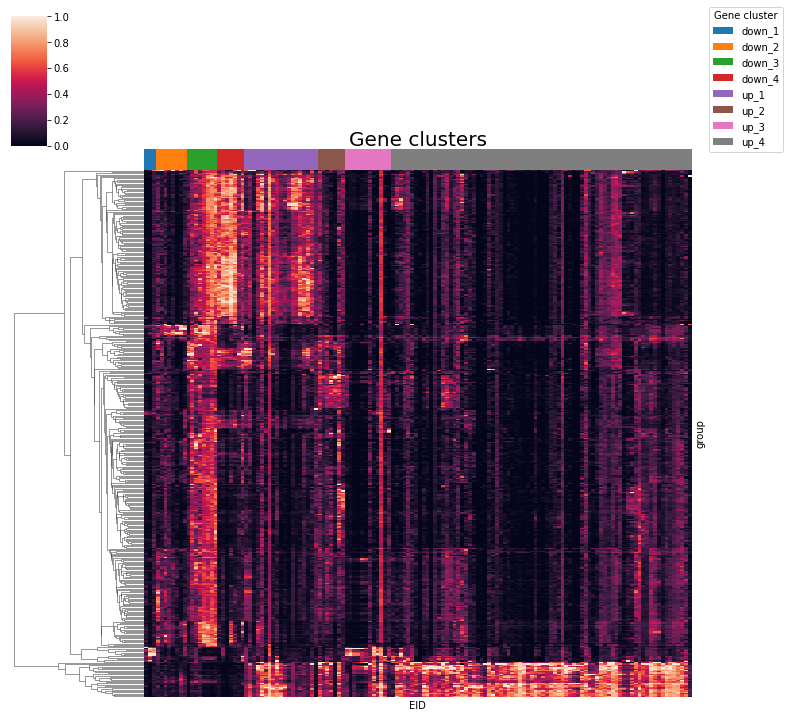

In [194]:
# Prepare some data for gene clusters heatmap
# Which clustering to show
gene_clustering='hc'
ad=adata_genes
# ordered genes by clusters
gene_list=[gene for cl in ad.obs[gene_clustering].cat.categories
           for gene in ad.obs_names[ad.obs[gene_clustering]==cl]]

# ordered gene colors 
cl_list=[ad.uns[gene_clustering+'_colors'][idx] for idx,cl in 
         enumerate(ad.obs[gene_clustering].cat.categories)
         for gene in ad.obs_names[ad.obs[gene_clustering]==cl]]

x_temp=pd.DataFrame( minmax_scale(ad.X.T),
                    index=ad.var_names,columns=ad.obs_names)[gene_list]

# Order within clusters
gene_list= h.opt_order_withincl(x_temp.T,ad.obs[gene_clustering])

fg=sb.clustermap(x_temp.loc[:,gene_list], 
              col_colors=cl_list, 
              col_cluster=False,row_cluster=True,
             xticklabels=False, yticklabels=False)
 # Adds block annotation titles as axis labels
fg.ax_col_colors.set_xlabel('Gene clusters',fontsize=20)
fg.ax_col_colors.xaxis.set_label_position('top') 
# legend for gene clusters
handles = [Patch(facecolor=c) for c in ad.uns[gene_clustering+'_colors']]
plt.legend(handles, adata_genes.obs[gene_clustering].cat.categories, title='Gene cluster',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)
del ad
del x_temp

Gene clusters scores on UMAP

In [13]:
# gene cluster scores
gene_cl='hc'
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(adata_genes.obs[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b, 
                      gene_list=adata_genes.obs_names[adata_genes.obs[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

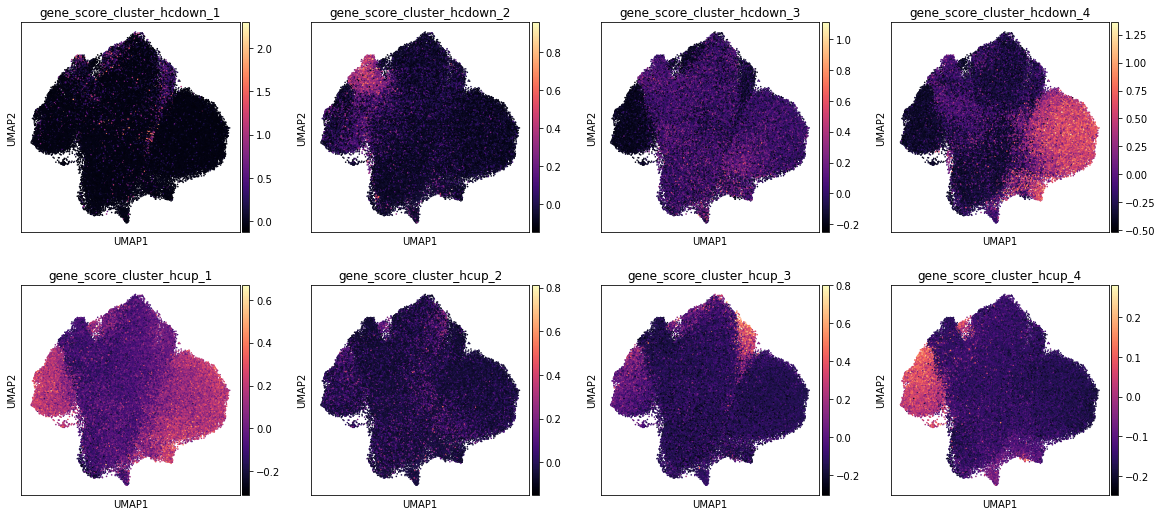

In [197]:
rcParams['figure.figsize']=(4,4)
random_indices=np.random.permutation(list(range(adata_rn_b.shape[0])))
sc.pl.umap(adata_rn_b[random_indices,:],color=[col for col in adata_rn_b.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not in col], color_map='magma',
           s=10,sort_order=False)

Gene group scores across samples, separated by sex

In [14]:
def color_variant(hex_color, brightness_offset=90):
    # Taken from 
    # https://chase-seibert.github.io/blog/2011/07/29/python-calculate-lighterdarker-rgb-colors.html
    """ 
    Takes a color like #87c95f and produces a lighter or darker variant
    For lighter take positive, for darker take negative
    """
    if len(hex_color) != 7:
        raise Exception("Passed %s into color_variant(), needs to be in #87c95f format." % hex_color)
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    new_rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    new_rgb_int = [min([255, max([0, i])]) for i in new_rgb_int] # make sure new values are between 0 and 255
    # hex() produces "0x88", we want just "88"
    return "#" + "".join([hex(i)[2:] for i in new_rgb_int])

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_symbol' as categorical


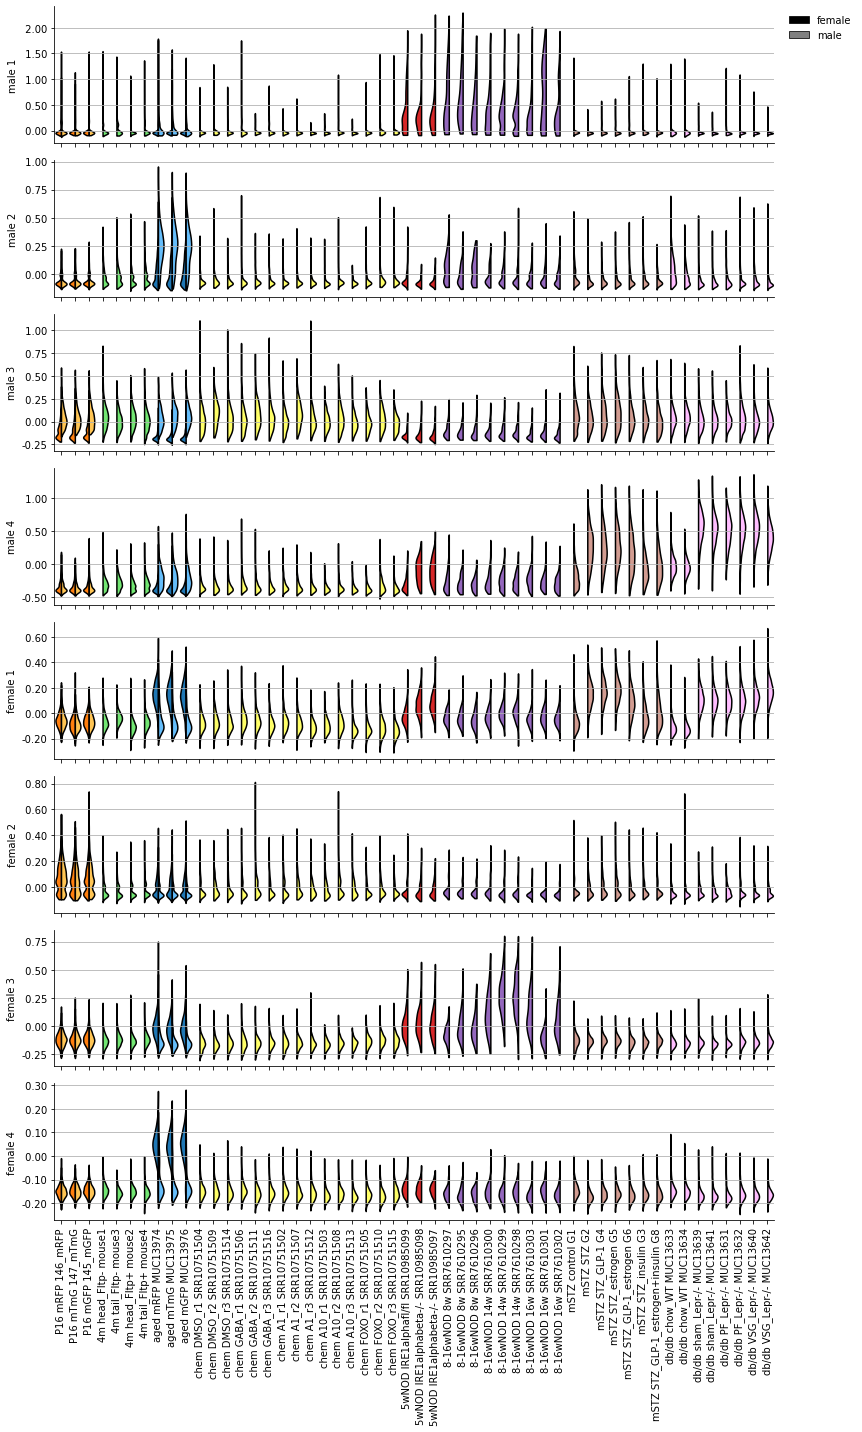

In [15]:
# Expression violin plot, separated by samples and colored by study and sex
adata_temp=adata_rn_b[adata_rn_b.obs.study!='embryo',:].copy()
# Sample order
adata_temp.obs['design']=pd.Categorical(adata_temp.obs['design'],
              categories=[ 
                  'E12.5','E13.5','E14.5', 'E15.5', 
              'mRFP','mTmG','mGFP',
              'head_Fltp-','tail_Fltp-', 'head_Fltp+', 'tail_Fltp+',
              'DMSO_r1','DMSO_r2', 'DMSO_r3','GABA_r1','GABA_r2', 'GABA_r3',
                   'A1_r1','A1_r2','A1_r3','A10_r1','A10_r2', 'A10_r3',  
                  'FOXO_r1', 'FOXO_r2', 'FOXO_r3',
              'IRE1alphafl/fl','IRE1alphabeta-/-', 
              '8w','14w', '16w',
              'control','STZ', 'STZ_GLP-1','STZ_estrogen', 'STZ_GLP-1_estrogen',
                  'STZ_insulin','STZ_GLP-1_estrogen+insulin' ,
              'chow_WT','sham_Lepr-/-','PF_Lepr-/-','VSG_Lepr-/-',   
            ],
            ordered=True)
adata_temp.obs['study_parsed']=pd.Categorical(
    adata_temp.obs['study_parsed'],ordered=True,
    categories=adata_rn_b.uns['study_parsed_order'])
adata_temp.obs['study_parsed_design_sample']=[
    ' '.join(i) for i in zip(
        adata_temp.obs['study_parsed'],adata_temp.obs['design'],adata_temp.obs['file'])]
# Violins that are plotted - if less than 2 cells seaborn does not plot it
adata_temp.obs['study_parsed_design_sample_sex']=[
    ':'.join(i) for i in zip(
        adata_temp.obs['study_parsed_design_sample'],adata_temp.obs['sex'])]
# Set to category to match order
adata_temp.obs['study_parsed_design_sample']=pd.Categorical(
    values=adata_temp.obs['study_parsed_design_sample'],ordered=True,
    categories=list(adata_temp.obs.drop_duplicates('study_parsed_design_sample'
                                             ).sort_values(['study_parsed','design']
                                                          ).study_parsed_design_sample)
)
adata_temp.obs['study_parsed_design_sample_sex']=pd.Categorical(
    values=adata_temp.obs['study_parsed_design_sample_sex'],ordered=True,
    categories=list(adata_temp.obs.drop_duplicates('study_parsed_design_sample_sex'
                                             ).sort_values(['study_parsed','design','sex']
                                                          ).study_parsed_design_sample_sex)
)
violin_categories=adata_temp.obs['study_parsed_design_sample_sex' ].value_counts( 
    dropna=False,sort=False)
violin_categories=violin_categories[violin_categories>1].index
# Color by study
palette=sc.plotting._tools.scatterplots._get_palette(adata_rn_b, 'study_parsed')
palette={sample:palette[adata_temp.obs.query(
    'study_parsed_design_sample==@sample').study_parsed[0]] 
       for sample in  adata_temp.obs['study_parsed_design_sample'].unique()}
cols=[col for col in adata_temp.obs.columns 
    if 'gene_score_cluster_hc' in col and '_scaled' not in col]
# Joined plot for all clusters
fig,axs=plt.subplots(len(cols),1,sharex=True,figsize=(12,2.5*len(cols)))
for idx,score in enumerate(cols):
    ax=axs[idx]
    ax.grid(b=True,axis='y')
    sc.pl.violin(adata_temp, 
                 keys=score, hue=adata_temp.obs['sex'],
                 groupby='study_parsed_design_sample', 
                 palette={'female':'black','male':'gray'},#palette=palette,
                 stripplot=False,rotation=90,ax=ax,split=True,
                 show=False,inner=None,frameon=False)
    # Set colors by study, make male lighter
    for idx_v,violin in enumerate(ax.findobj(matplotlib.collections.PolyCollection)):
        sample,sex=violin_categories[idx_v].split(':')
        color=palette[sample]
        if sex=='male':
            color=color_variant(color,brightness_offset=70)
        violin.set_facecolor(matplotlib.colors.to_rgb(color))
    # Show legend for first plot
    if idx==0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1.12,1),frameon=False)
    else:
        ax.get_legend().remove()
    # Transparent
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(score.replace('gene_score_cluster_hc','').\
                  replace('down_','male ').replace('up_','female '))
    # Format to same precision across plots
    ax.yaxis.set_major_formatter(FormatStrFormatter('% .2f'))
plt.subplots_adjust(wspace=0, hspace=0)

fig.tight_layout()
plt.savefig(path_fig+'violin_beta_sexagedDEcl_samples.png',dpi=300,bbox_inches='tight')

del adata_temp

Expression summary:

Male:
- down_1: +NOD
- down_2: old male
- down_3: +male
- down_4: +T2D

Female:
- up_1: +T2D
- up_2: +young/immature
- up_3: +NOD/T1D
- up_4: old female

#### Expression summary across cell states
Make plot more concise

Which clusters have male/female cells that can be plotted separately

In [11]:
# N cells per sex and ct
display(pd.crosstab(adata_rn_b.obs['leiden_r1.5_parsed'],adata_rn_b.obs.sex))
display(pd.crosstab(adata_rn_b.obs['leiden_r1.5_parsed'],adata_rn_b.obs.sex,normalize='index'))

sex,female,male
leiden_r1.5_parsed,,
T1D,2635,278
T2D,587,29795
adult,847,9244
aged_female,8024,1046
aged_male,533,7280
chem,712,13405
immature,6924,18051
low_quality,13,1580
low_quality_highMT,121,1068


sex,female,male
leiden_r1.5_parsed,,
T1D,0.904566,0.095434
T2D,0.019321,0.980679
adult,0.083936,0.916064
aged_female,0.884675,0.115325
aged_male,0.068220,0.931780
chem,0.050436,0.949564
immature,0.277237,0.722763
low_quality,0.008161,0.991839
low_quality_highMT,0.101766,0.898234


C: If less than 15% of cells in ct from one sex then do not show this sex (as we do not expect some sexes there anyways). Also exclude low quality.

In [16]:
# Remove low quality
obs_sub=adata_rn_b.obs.copy()
print(obs_sub.shape)
obs_sub=obs_sub.query('~`leiden_r1.5_parsed`.str.contains("lowQ")',
                      engine='python').copy()
print(obs_sub.shape)

(102143, 86)
(99361, 86)


In [17]:
# Remove rare sex in ct
for ct,row in pd.crosstab(obs_sub['leiden_r1.5_parsed'],
                              obs_sub.sex,normalize='index').iterrows():
    for sex,val in row.iteritems():
        if val<0.15:
            print(ct,sex)
            obs_sub=obs_sub[~((obs_sub['leiden_r1.5_parsed']==ct).values &
                         (obs_sub['sex']==sex).values)]
print(obs_sub.shape)    
obs_sub['leiden_r1.5_parsed_sex']=[c+' '+s for c,s in zip(
    obs_sub['leiden_r1.5_parsed'],obs_sub['sex'])]
print(sorted(obs_sub['leiden_r1.5_parsed_sex'].unique()))

adult female
agedF male
agedM female
NOD-D male
db/db+mSTZ female
chem female
(95490, 86)
['NOD-D female', 'adult male', 'agedF female', 'agedM male', 'chem male', 'db/db+mSTZ male', 'imm. female', 'imm. male']


In [20]:
# Mean score per cluster_sex
data_plot=obs_sub.groupby('leiden_r1.5_parsed_sex')[
    [c for c in obs_sub if 'gene_score_cluster_hc' in c and '_scaled' not in c]].mean()
# Normalize scores across clusters
data_plot=pd.DataFrame(minmax_scale(data_plot),index=data_plot.index,columns=data_plot.columns)
# rename clusters and make sex anno for rows and cols
sex_cmap={'male':'#8a9e59','female':'#c97fac'}
row_anno=pd.Series([i.split()[1] for i in data_plot.index],name='cell sex' ).map(sex_cmap)
data_plot.index=[i.split()[0]+' - '+i.split()[1][0].upper() for i in data_plot.index]
row_anno.index=data_plot.index
data_plot.columns=[c.replace('gene_score_cluster_hc','').replace('down_','male ').\
                   replace('up_','female ') for c in data_plot.columns]
col_anno=pd.Series([c.split()[0] for c in data_plot.columns],name='upregulated sex',
                   index=data_plot.columns).map(sex_cmap)

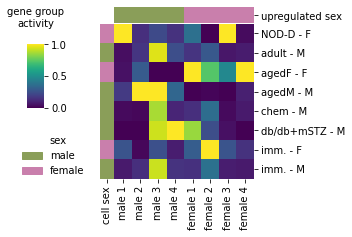

In [21]:
# Sizes
w_dend=1.3
w_colors=0.3
nrow=data_plot.shape[0]*0.37
ncol=data_plot.shape[1]*0.35
w=ncol+w_dend+w_colors
h=nrow+w_colors+w_dend
# Heatmap
g=sb.clustermap(data_plot,cmap='viridis',vmin=0,vmax=1,
                col_cluster=False,row_cluster=False,
              row_colors=row_anno,col_colors=col_anno,
              figsize=(h,w),
             colors_ratio=(w_colors/h,w_colors/w),
            dendrogram_ratio=(w_dend/h,w_dend/w),
                cbar_pos=(0,0.42,0.05,0.2))
g.ax_cbar.set_title('gene group\nactivity\n',fontsize=10)   

#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# Legend for species and diabetes
l=plt.legend(handles=\
             [mpatches.Patch(alpha=0, label='sex')]+
             [mpatches.Patch(color=c, label=l) 
                      for l,c in sex_cmap.items()],
          bbox_to_anchor=(4,-0.3))
l.get_frame().set_alpha(0)

# Save
plt.savefig(path_fig+'heatmap_beta_sexagedDEcl_coarseCLsex.png',
            dpi=300,bbox_inches='tight')

Same heatmap as above but with column gaps

In [46]:
# Add to R expression and de direction
ro.globalenv['x']=data_plot
de_group=[c.split()[0] for c in data_plot.columns]
ro.globalenv['de_group']=de_group
de_groups_order=list(dict.fromkeys(de_group))
ro.globalenv['de_groups_order']=de_groups_order
ro.globalenv['de_groups_order_parsed']=[g+' up' for g in de_groups_order]
ro.globalenv['de_groups_colors']=[sex_cmap[c] for c in de_groups_order]
ro.globalenv['cell_sex']=[i.split('- ')[1].replace('F','female').replace('M','male') 
                          for i in data_plot.index]

In [81]:
%%R
# DE direction anno
de_groups_order<-unlist(de_groups_order)
de_groups_colors<-unlist(de_groups_colors)
ha_col = columnAnnotation(
    direction = anno_block(gp = gpar(fill = de_groups_colors, col='white'), 
                           labels = unlist(de_groups_order_parsed),
                            labels_gp = gpar(col = "white"),),
    annotation_name_side = "left"
)
# Order DE groups
de_group<-factor(as.vector(unlist(de_group)),levels = de_groups_order)

In [82]:
%%R
# Cell sex annotation
# Prepare sex order
sex_anno<-factor(cell_sex,levels = de_groups_order)
ha_row = rowAnnotation(
    sex=sex_anno,
    col = list(sex = setNames(  de_groups_colors,de_groups_order)),
    annotation_name_side = "bottom",
    annotation_legend_param = list( 
        sex =list(
            title = "sex",
            title_gp=gpar( fontsize = 12),
            labels_gp = gpar( fontsize = 12)))
)

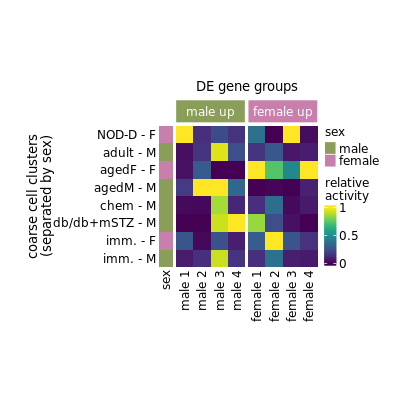

In [94]:
%%R -w 400 -h 400 
# plot heatmap
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = TRUE, show_row_names = TRUE,
       row_title ="coarse cell clusters\n(separated by sex)",
       top_annotation=ha_col,
       left_annotation=ha_row,
       column_split =de_group,
       column_title = 'DE gene groups',
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nactivity", 
                                   title_gp=gpar( fontsize = 12),
                                   labels_gp = gpar( fontsize = 12)),
       row_gap = unit(1, "mm"),
       width= unit(5, "cm"), height= unit(5, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

In [92]:
%%R -i path_fig
# Save heatmap
pdf(file=paste0(path_fig,"heatmap_beta_sexagedDEcl_coarseCLsex_gaps.pdf"), 
    width=4.9, height=3.4)
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = TRUE, show_row_names = TRUE,
       row_title ="coarse cell clusters\n(separated by sex)",
       top_annotation=ha_col,
       left_annotation=ha_row,
       column_split =de_group,
       column_title = 'DE gene groups',
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nactivity", 
                                   title_gp=gpar( fontsize = 12),
                                   labels_gp = gpar( fontsize = 12)),
       row_gap = unit(1, "mm"),
       width= unit(5, "cm"), height= unit(5, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

### Top DE genes
Prioritise DE genes from each cluster based on lFC or citations (top 20 genes). 

In [200]:
adata_genes.obs['log2FC']=summary.loc[adata_genes.obs_names,'log2fc']
adata_genes.obs['gene_symbol']=adata_rn_b.var.loc[adata_genes.obs_names,'gene_symbol']
for cl,data in adata_genes.obs.groupby('hc'):
    print('\n'+cl)
    print('Most DE:')
    print(data.sort_values('log2FC',key=abs,ascending=False
                          ).head(20).gene_symbol.to_list())
    print('Most cited wrt beta cells:')
    print(genes_info.loc[data.index,:].\
            sort_values('N_PMID_pancreas_notCancerNonendo').head(20).apply(
        lambda x: x['gene_symbol'] if isinstance(x['gene_symbol'],str) else x.name,axis=1).to_list())


down_1
Most DE:
['BC023719', 'Serpinh1', 'Npy']
Most cited wrt beta cells:
['BC023719', 'Serpinh1', 'Npy']

down_2
Most DE:
['Reln', 'Pcdh15', 'Ppargc1a', 'Nptx1', 'Tcim', 'Hspa1b', 'Diras2', 'Cit']
Most cited wrt beta cells:
['Reln', 'Tcim', 'Nptx1', 'Diras2', 'Cit', 'Pcdh15', 'Hspa1b', 'Ppargc1a']

down_3
Most DE:
['Uty', 'Ddx3y', 'Eif2s3y', 'Kdm5d', 'Pcp4', 'Fxyd3', 'Lancl3', 'Nr1h4']
Most cited wrt beta cells:
['Lancl3', 'Fxyd3', 'Pcp4', 'Kdm5d', 'Uty', 'Ddx3y', 'Eif2s3y', 'Nr1h4']

down_4
Most DE:
['Aldh1a3', 'Pappa2', 'Gc', 'Slc35f4', 'Gria3', 'Depp1', '6330403K07Rik']
Most cited wrt beta cells:
['Pappa2', 'Gria3', '6330403K07Rik', 'Depp1', 'Aldh1a3', 'Slc35f4', 'Gc']

up_1
Most DE:
['Sftpd', 'Mctp1', 'Aqp4', 'Chgb', 'Rpgrip1', 'Gpx3', 'Wipi1', 'Eef1a2', 'Bcat1', 'Mapk4', 'Car8', 'nan', 'Enox1', 'Mospd1', 'Pdzrn3', 'Palmd', 'Cntn3', 'C8b', 'Dct']
Most cited wrt beta cells:
['ENSMUSG00000021745', 'Mctp1', 'Wipi1', 'Enox1', 'Rpgrip1', 'Cntn3', 'Mapk4', 'C8b', 'Car8', 'Palmd', 'Mos

### Gene set enrichment of gene groups

In [20]:
# Ref genes
ref=adata_rn_b.var.loc[summary.index,'gene_symbol'].tolist()
ro.globalenv['ref']=ref

# Get gene sets
print('MSIGdb version:',ro.r(f'msigdb_version()'))
gene_sets_go=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C5',subcategories=c('GO:BP','GO:CC','GO:MF'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_kegg=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('KEGG'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
gene_sets_reactome=ro.r(f"msigdb_gsets_custom(species='Mus musculus',category='C2',subcategories=c('REACTOME'),size_range=c(5,500),filter_gene_sets=NULL,background=ref)")
%R -i gene_sets_go -i gene_sets_kegg -i gene_sets_reactome -o gene_sets gene_sets=c(gene_sets_go,gene_sets_kegg,gene_sets_reactome)
print('N gene sets:',len(gene_sets))
ro.globalenv['gene_sets']=gene_sets

MSIGdb version: ['v7.4.1']
N gene sets: 8904


CL down_1 N genes 3
N enriched gene sets: 0
CL down_2 N genes 8
N enriched gene sets: 3
Top enriched gene sets


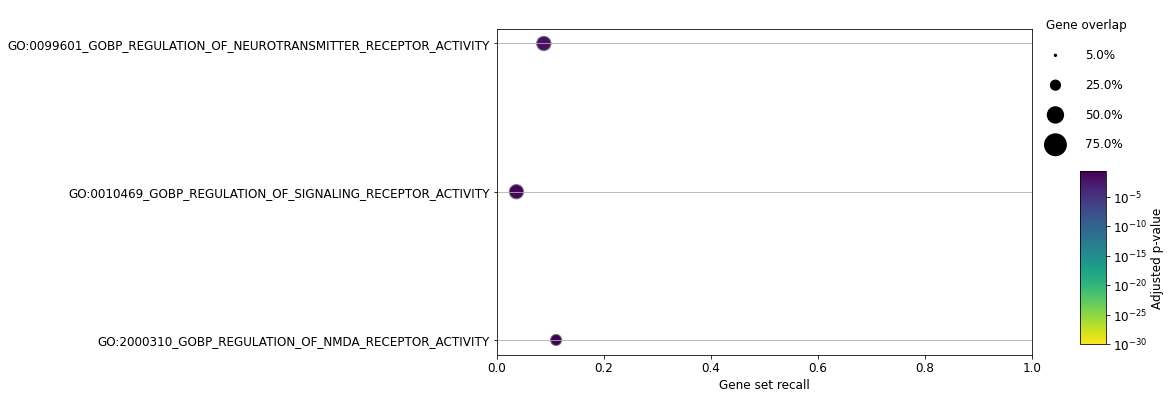

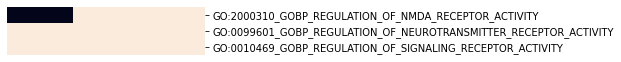

CL down_3 N genes 8
N enriched gene sets: 0
CL down_4 N genes 7
N enriched gene sets: 0
CL up_1 N genes 19
N enriched gene sets: 0
CL up_2 N genes 7
N enriched gene sets: 0
CL up_3 N genes 12
N enriched gene sets: 6
Top enriched gene sets


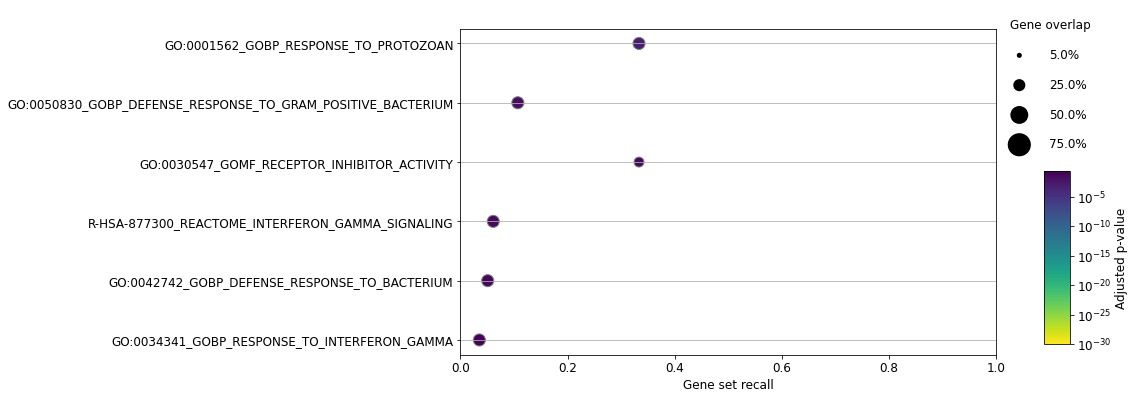

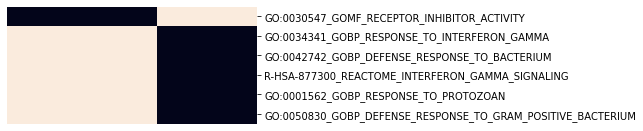

CL up_4 N genes 78
N enriched gene sets: 7
Top enriched gene sets


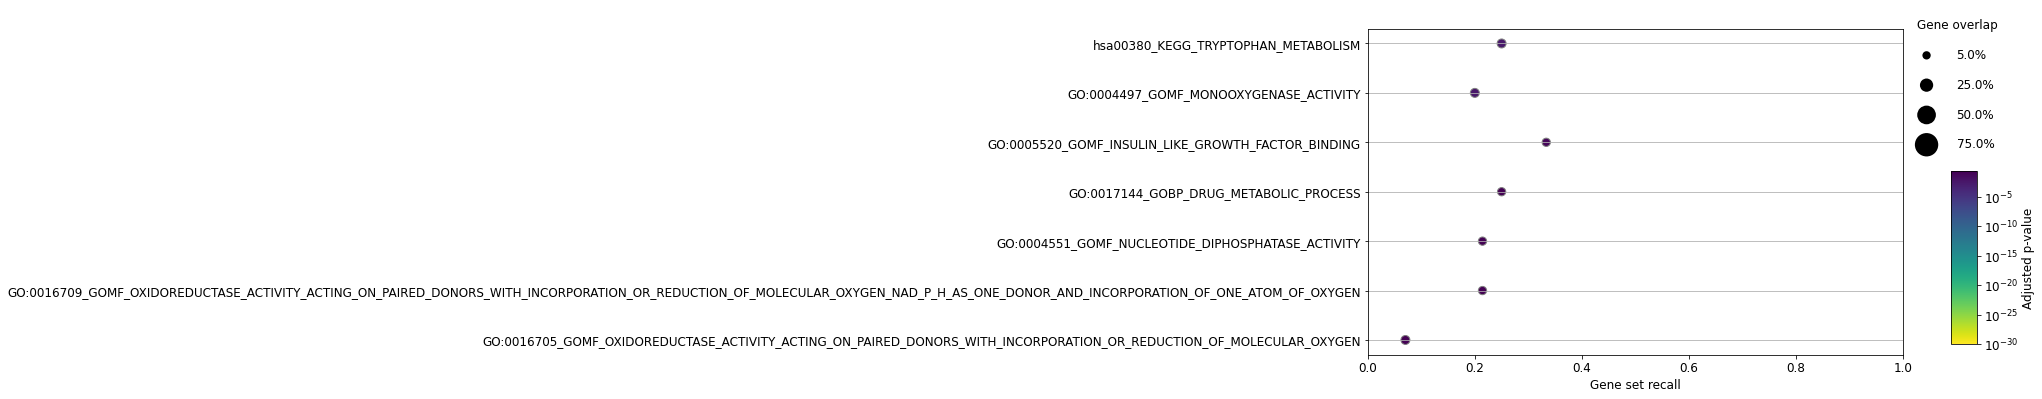

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


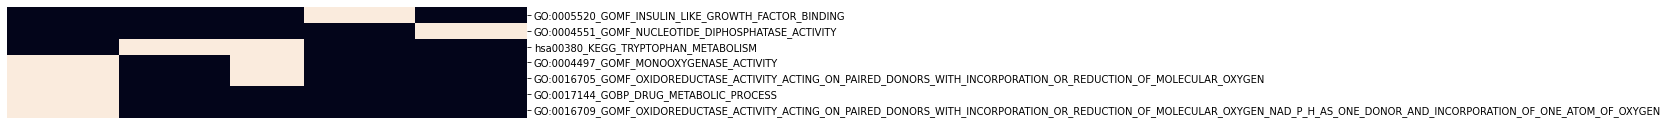

In [22]:
enrich_fdr=0.25
ro.globalenv['gs_fdr']=enrich_fdr
enrich_datas={}
for cl in sorted(adata_genes.obs['hc'].unique()):
    genes=adata_genes.obs.query('hc==@cl').index
    print('CL %s N genes %i'%(cl,len(genes)))
    # Map to gene symbols
    genes=adata_rn_b.var.loc[genes,'gene_symbol'].tolist()

    # Calculate enrichment
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    enrich_datas[cl]=data
    print('N enriched gene sets:',data.shape[0])
    
    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)
# Save enrichment tables
writer = pd.ExcelWriter(path_de+'deDataClusters_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enrich_datas.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()

C: It seems there are not enough genes per group to create sensible enrichment.

## Save

In [15]:
# Add data to De summary
summary_data=summary.copy()
summary_data['hc']=adata_genes.obs.copy().reindex(summary_data.index.values)['hc']
summary_data['gene_symbol']=adata_rn_b.var.loc[summary_data.index,'gene_symbol']
summary_data['rel_beta_expr']=genes_info.loc[summary_data.index,'rel_maxscl_beta_expr_cl'].values
summary_data[['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]=\
    genes_info.loc[summary_data.index,
                   ['mean_expr_in_expr_cells','N_PMID','N_PMID_pancreas_notCancerNonendo']]
summary_data['hc']=adata_genes.obs.copy().reindex(summary_data.index.values)['hc']

In [16]:
summary_data

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll,hc,gene_symbol,rel_beta_expr,mean_expr_in_expr_cells,N_PMID,N_PMID_pancreas_notCancerNonendo
gene,,,,,,,,,,,,,,,,
ENSMUSG00000051951,ENSMUSG00000051951,0.000000e+00,0.000000e+00,0.729754,0.096120,False,7.940045e-08,0.729754,0.063924,-4714.605539,NaN,Xkr4,1.000000,0.487778,11.0,0.0
ENSMUSG00000033845,ENSMUSG00000033845,8.174452e-07,1.503167e-06,0.141079,0.452256,False,1.538251e-06,0.141079,0.028610,-12475.058608,NaN,Mrpl15,0.577643,0.665728,55.0,0.0
ENSMUSG00000025903,ENSMUSG00000025903,2.833213e-08,5.743214e-08,0.150064,0.546622,False,1.498951e-06,0.150064,0.027032,-14285.212961,NaN,Lypla1,0.755665,0.617923,42.0,0.0
ENSMUSG00000033813,ENSMUSG00000033813,0.000000e+00,0.000000e+00,0.159760,1.343226,False,1.621427e-06,0.159760,0.018504,-22047.210763,NaN,Tcea1,0.898695,0.794732,66.0,0.0
ENSMUSG00000033793,ENSMUSG00000033793,1.288747e-10,3.040068e-10,0.129402,1.082158,False,1.753754e-06,0.129402,0.020129,-20026.859932,NaN,Atp6v1h,1.000000,0.706451,65.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064368,ENSMUSG00000064368,0.000000e+00,0.000000e+00,0.283973,0.562759,False,7.021447e-08,0.283973,0.033230,-14590.166850,NaN,mt-Nd6,1.000000,0.684435,42.0,4.0
ENSMUSG00000064370,ENSMUSG00000064370,3.596830e-04,5.384486e-04,0.032460,190.210342,False,1.024241e-06,0.032460,0.009097,-84573.885796,NaN,mt-Cytb,1.000000,4.252210,39.0,5.0
ENSMUSG00000051412,ENSMUSG00000051412,0.000000e+00,0.000000e+00,0.634761,1.314179,False,2.930141e-07,0.634761,0.019659,-21393.940985,NaN,Vamp7,1.000000,0.746626,0.0,0.0


In [18]:
# Save
summary_data.to_csv(path_de+'deDataClusters.tsv',index=False,sep='\t')